# 과제 목표

1. 대규모 데이터로 미리 학습된 CLIP 모델로 이미지 혹은 텍스트의 CLIP feature를 추출하는 방법을 학습
2. CLIP 모델을 활용하여 추가 학습이 없는 제로샷 이미지 분류기 구현

# 환경 세팅

본 실습에서 사용할 라이브러리를 import 하겠습니다. Colab을 사용할 경우, 아래 명령어로 CLIP을 추가 설치해주세요.

In [1]:
# Colab 사용 시
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v2yu_gg5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v2yu_gg5
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=21447eb8688d857c872e0786a2a047b6a6267b3e02ea39d528e06df7dd46a11e
  Stored in directory: /tmp/pip-ephem-wheel-cache-xsq_6mqn/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import random
import torch
import torchvision
import matplotlib.pyplot as plt
import clip

# CLIP으로 제로샷 이미지 분류기 만들기

CLIP 활용의 실습으로, 기학습된 CLIP 모델로 이미지 분류기를 따로 학습하지 않고도 이미지 분류를 수행해보겠습니다.

본 실습에 사용할 설정값을 지정하겠습니다.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cifar100_dataset_path = './datasets'

본 실습에서는 huggingface에서 제공하는 CLIP 모델을 사용합니다. 사용 예시와 다양한 모델에 대한 docs는 아래 링크를 참조해주세요!

https://huggingface.co/docs/transformers/model_doc/clip

In [4]:
# CLIP 모델 및 이미지 프로세서 불러오기
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 96.1MiB/s]


데이터셋은 SUB PJT 1에서 사용한 CIFAR-10보다 더 클래스가 많은 CIFAR-100 데이터셋을 사용하겠습니다.

In [6]:
# Load dataset
dataset = torchvision.datasets.CIFAR100(
    cifar100_dataset_path, train=False, download=True,
)

100%|██████████| 169001437/169001437 [00:05<00:00, 30766949.17it/s]


Extracting ./datasets/cifar-100-python.tar.gz to ./datasets


## 1. 라벨 텍스트 토큰화하기

텍스트(라벨)의 CLIP feature를 얻기 위해선 텍스트를 토큰화해야 합니다. "a photo of a {LABEL}" 형식으로 CIFAR-100 데이터셋의 라벨 정보를 토큰화하여 리스트로 저장합니다.

In [7]:
############################################################################
# Req 2-1: 라벨 텍스트 토큰화하기                                              #
############################################################################

################################################################################
# TODO: 데이터셋 내 라벨을 이용하여 이미지를 설명하는 텍스트를 만들고, 각 텍스트의        #
# 토큰화를 진행함                                                                 #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# 1) 데이터셋 내 클래스(라벨)을 리스트화함
# 2) 클래스(라벨)을 이용하여 "a photo of a {LABEL}" 형태의 텍스트를 tokenize함


# 데이터셋 내 클래스(라벨)을 리스트화함
labels = dataset.classes

# 클래스(라벨)을 이용하여 "a photo of a {LABEL}" 형태의 텍스트를 tokenize함
text_inputs = [clip.tokenize(f"a photo of a {label}") for label in labels]
text_inputs = torch.cat(text_inputs).to(device)

print(f"Number of labels: {len(text_inputs)}")
print("Result of tokenization (for random 3 labels)")
random_text = random.sample(list(text_inputs), 3)
for i in range(len(random_text)):
    print(random_text[i])

Number of labels: 100
Result of tokenization (for random 3 labels)
tensor([49406,   320,  1125,   539,   320,   786, 49407,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)
tensor([49406,   320,  1125,   539,   320, 10945, 49407,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   

## 2. 이미지와 라벨 텍스트 간 CLIP feature 유사도 계산하기

이미지 클래스(라벨)의 CLIP text feature와 분류 대상의 입력 이미지의 CLIP image features 간 top-K 유사도를 구하는 함수를 작성하겠습니다.

In [8]:
############################################################################
# Req 2-2: 이미지와 라벨 텍스트 간 유사도 계산하기                               #
############################################################################

def calc_similarities(image, text_inputs, topk):
    """Calulate cosine similarities between image features and text features.

    Args:
        image (torch.Tensor): Image to classify the label
        text_inputs (torch.Tensor): Tokenized texts containing label information
        topk (int): How many indices (classes) to extract as an answer
    Returns:
        top_sim_scores (torch.Tensor): Top-K similarity scores
        top_indices (torch.Tensor): Top-K indices (order of nubmers matched with `top_sim_scores`)
    """
    ################################################################################
    # TODO: 이미지를 텐서화하고, 그리드를 이용하여 k 개의 이미지를 한 번에 나타냄            #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1) 이미지를 CLIP 전처리를 통하여 전처리함
    image_preprocessed = preprocess(image).unsqueeze(0).to(device)

    # 2) 라벨 정보를 담은 텍스트와 입력 이미지 각각의 CLIP feature를 구함
    with torch.no_grad():
        image_features = model.encode_image(image_preprocessed)
        text_features = model.encode_text(text_inputs)

    # 3) Image feature와 text feature의 코사인 유사도를 구함
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = (image_features @ text_features.T).squeeze(0)

    # 4) 코사인 유사도에 softmax를 취하여 총합을 1로 만듦
    softmax_similarities = torch.softmax(similarities, dim=-1)

    # 5) Top-K 값과 이에 해당하는 인덱스를 추출함
    top_sim_scores, top_indices = torch.topk(softmax_similarities, topk)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    return top_sim_scores, top_indices

아래 코드로 `calc_similarities` 함수를 테스트할 수 있습니다.

이미지 분류를 테스트할 대상 이미지를 무작위로 선택하고, 몇 개의 분류 예측을 뽑을 것인지 Top-K 숫자도 지정합니다. 이후 `calc_similarities` 함수를 이용하여 예측 결과를 확인합니다.

Label (answer): palm_tree

Top 10 Classification Results:
palm_tree      : 1.09%
pine_tree      : 1.06%
willow_tree    : 1.05%
oak_tree       : 1.04%
maple_tree     : 1.04%
house          : 1.03%
lawn_mower     : 1.03%
aquarium_fish  : 1.02%
lamp           : 1.02%
sweet_pepper   : 1.02%


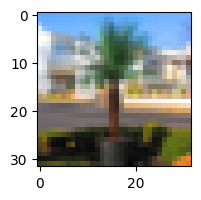

In [9]:
# Select random image from dataset
image_idx = random.randint(0, len(dataset))
image, label_idx = dataset[image_idx]

# Draw image
plt.figure(figsize=(2, 2))
plt.imshow(image)

# Select K to show Top-K classification result
K = 10

# Calculate the similarites between image and labels
# and classify the image with similarity scores
sim_scores, indices = calc_similarities(image, text_inputs, K)

print(f"Label (answer): {dataset.classes[label_idx]}\n")
print(f"Top {K} Classification Results:")
for score, idx in zip(sim_scores, indices):
    print(f"{dataset.classes[idx]:15s}: {score.item()*100:.2f}%")